### Time Series Prediction and Forecast using Proba-V, Landsat 8  imagery and CHIRPS Precipitation data
**Author:** René Kopeinig<br>
**Description:** Time Series Prediction using Proba-V NDVI (Normalized Difference Vegetation Index) imagery. This tutorial will show you a few different approaches (Extrapolation, ARIMA and Facebook Prophet) on how to make prediction and forecasts in the future with unseen data.

In [1]:
%matplotlib inline

In [20]:
import ee, datetime
import pandas as pd
import matplotlib.dates as mdates
from IPython.display import Image
from matplotlib import dates
from pylab import *
from numpy import fft
from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
ee.Initialize()

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Load Proba-V, Landsat 8 TOA and CHIRPS  image collection and point geometry
Selected Location of point is from the Proba-V Footprint X18Y02 in Luxembourg, Europe. 

In [3]:
# Set start and end date
startTime = datetime.datetime(2013, 2, 3)
endTime = datetime.datetime(2019, 5, 25)

# Create image collection
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_RT').filterDate(startTime, endTime)
precipitation = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').filterDate(startTime, endTime)
probav = ee.ImageCollection('VITO/PROBAV/C1/S1_TOC_100M').filterDate(startTime, endTime)
point = {'type':'Point', 'coordinates':[-99.545934,20.572173]};

### Retrieve information, reshape & calculate NDVI and extract precipitation information
Retrieving information from point geometry with a buffer of 500m over image collection. Reshaping data and calculating NDVI from **RED** and **NIR** band.

In [4]:
#Retrieve information over image collection
info_l8 = l8.getRegion(point,500).getInfo()
info_chirps = precipitation.getRegion(point, 500).getInfo()
info_probav = probav.getRegion(point, 500).getInfo()

In [5]:
# Reshape Proba-V image collection 
header = info_probav[0]
data = array(info_probav[1:])
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

band_list=['NDVI']
iBands = [header.index(b) for b in band_list]
ndvi = data[0:,iBands].astype(np.float)

df = pd.DataFrame(data=ndvi, index=time, columns=['ndvi'])
probav_time_series = df.dropna()

# Resampling
monthly_probav = probav_time_series.resample('M', how='mean')

/Users/rkopei/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).mean()



In [6]:
# Reshape Chirps precipitation data 
header = info_chirps[0]
data = array(info_chirps[1:])
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

band_list=['precipitation']
iBands = [header.index(b) for b in band_list]
chirps = data[0:,iBands].astype(np.float)

df = pd.DataFrame(data=chirps, index=time, columns=['precipitation'])
chirps_time_series = df.dropna()

# Resampling
monthly_chirps = chirps_time_series.resample('M', how='mean')

/Users/rkopei/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).mean()



In [7]:
# Reshape Landsat 8
header = info_l8[0]
data = array(info_l8[1:])

iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

# List of used image bands
band_list = ['B5',u'B4']

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)

# Reshape NDVI array into Pandas Dataframe
df = pd.DataFrame(data=ndvi*-1, index=time, columns=['ndvi'])
df_red=pd.DataFrame(data=red, index=time, columns=['red'])
l8_time_series = df.dropna()

# Resampling
monthly_landsat = l8_time_series.resample('M', how='mean')

/Users/rkopei/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).mean()



### Plot weekly and monthly Proba-V NDVI Time Series

Text(0.5, 1.0, 'Weekly')

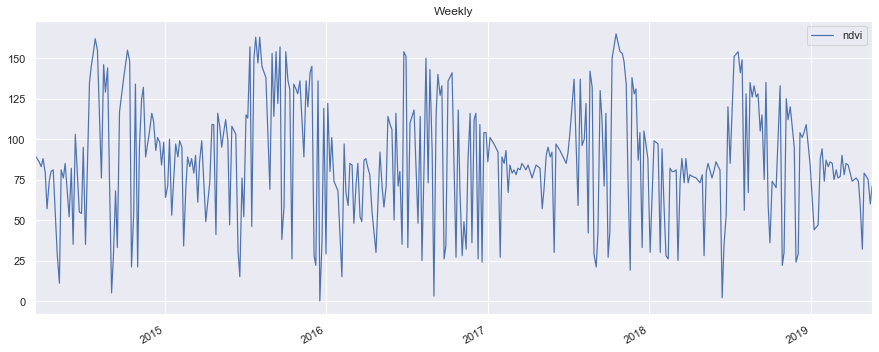

In [9]:
sns.set(rc={'figure.figsize':(15, 6)})
probav_time_series.plot(linewidth=1.2)
plt.title('Weekly')

Text(0.5, 1.0, 'Monthly')

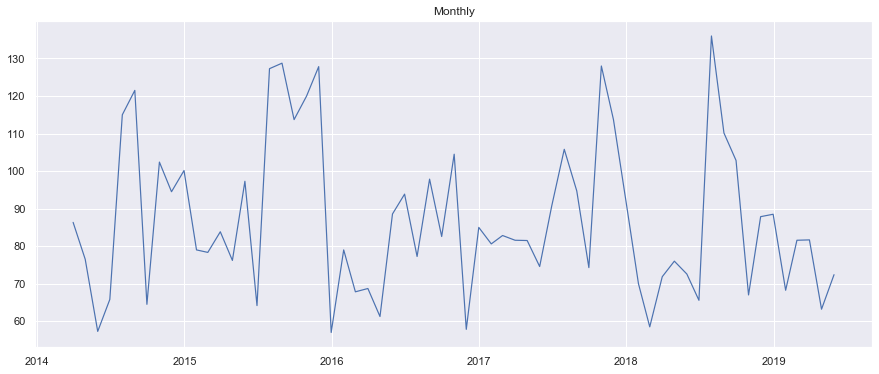

In [11]:
plt.plot(monthly_probav['ndvi'], linewidth=1.2)
plt.title('Monthly')

###  ARIMA Model 
Time Series Prediction applying Autoregressive Integrated Moving Average.

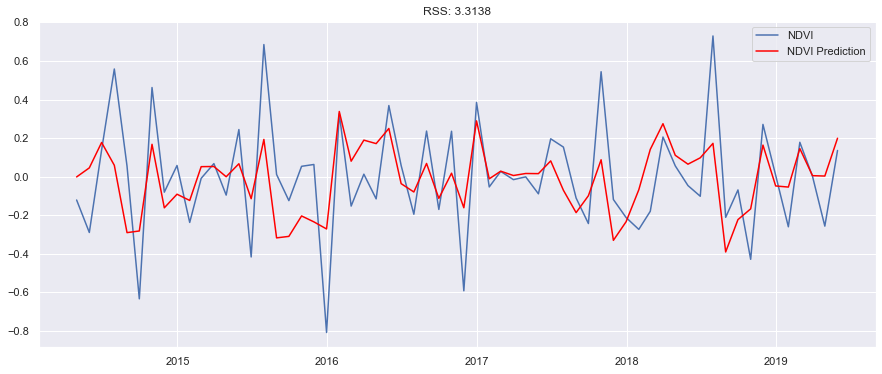

In [12]:
def arima_model(series):
    log_series = series.apply(lambda x: np.log(x))
    log_series_diff=log_series-log_series.shift()

    model=ARIMA(log_series, order=(1,1,1))
    results_ARIMA = model.fit(disp=-1)
    
    RSS = np.nansum((results_ARIMA.fittedvalues-log_series_diff)**2)
    return RSS, log_series_diff, results_ARIMA


RSS, log_series_diff, arima = arima_model(monthly_probav['ndvi'])
plt.plot(log_series_diff)
plt.plot(arima.fittedvalues, color='red')
plt.title('RSS: %.4f'% RSS)
plt.legend(['NDVI', 'NDVI Prediction'])

### Fourier Extrapolation 
Applying Fourier Extrapolation in order to define a continuation pattern of the Proba-V NDVI time series. 

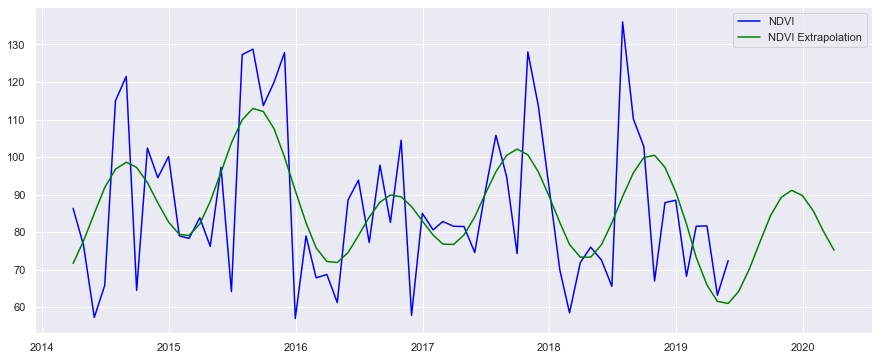

In [14]:
def fourierExtrapolation(series, n_predict):
    t = np.arange(0, series.size)
    p = np.polyfit(t, series, 1)
    x_notrend = series - p[0] * t
    x_freqdom = fft.fft(x_notrend)
    f = fft.fftfreq(series.size)
    indexes = list(range(series.size))
    indexes.sort(key=lambda i: np.absolute(f[i]))
    t = np.arange(0, series.size  + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + 5 * 2]:
        ampli = np.absolute(x_freqdom[i]) / series.size
        phase = np.angle(x_freqdom[i])
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    extrapolation = restored_sig + p[0] * t
    predicted = pd.DataFrame(data=extrapolation, columns=['predicted'])
    first = series.head(1).index[0]
    date_array = np.arange(first, len(series)+10, dtype='datetime64[M]')
    _index = pd.to_datetime(date_array)
    index = pd.to_datetime(_index, format="%Y%m") + MonthEnd(1)
    return predicted.set_index(index)

extrapolation=fourierExtrapolation(monthly_probav['ndvi'], 10)
plt.plot(monthly_probav, color='blue')
plt.plot(extrapolation, color='green')
plt.legend(['NDVI','NDVI Extrapolation'])

### Reshape Data and plot
Let's bring all Time Series on an equal base, reshape and join them in one data frame. Creating Pair Plots in order to take a closer look into the data.

In [15]:
monthly = pd.DataFrame({'landsat': monthly_landsat['ndvi'],
                        'chirps': monthly_chirps['precipitation'],
                        'probav':monthly_probav['ndvi']},index = monthly_chirps.index)

### Time Series Forecast using Facebook Prophet
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

In [16]:
# Reshape data for Forecast
monthly['y'] = monthly['probav']
monthly['ds'] = monthly.index
period=len(monthly_probav['ndvi']['2017-01-01':])
monthly=monthly['2014-01-01':'2016-12-31']

# Forecasting Proba-V data using Chirps and Landsat as regressors 
m = Prophet(yearly_seasonality=15,seasonality_mode='additive')
m.add_regressor('chirps')
m.add_regressor('landsat')
m.fit(monthly)

# Create future dataframe
future = m.make_future_dataframe(periods=period, freq='M', include_history=False)
future['chirps']=0
future['landsat']=0

# Forecast
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Plot Time Series Forecast Results

Text(0.5, 1.0, 'Proba-V Monthly Forecast')

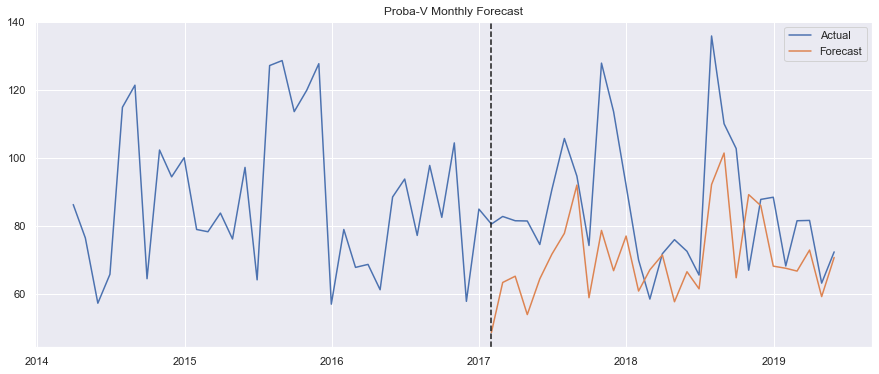

In [18]:
# Plot results
plt.plot(monthly_probav.index,monthly_probav.ndvi)
plt.plot(forecast.ds,forecast.yhat)
plt.axvline(x=forecast.ds.values[0], color='k', linestyle='--')
plt.legend(['Actual', 'Forecast'])
plt.title('Proba-V Monthly Forecast')

In [28]:
print('Mean Absolute Percentage Error: ',mean_absolute_percentage_error(monthly_probav.ndvi.tail(len(forecast.yhat)).values,forecast.yhat.values))

Mean Absolute Percentage Error:  18.544756393304173
